<a href="https://colab.research.google.com/github/kartoone/cosc470/blob/main/keras/mnist-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras import ops

In [2]:
def reset_model(model):
    new_model = keras.models.clone_model(model)
    new_model.build(model.input_shape)  # Build the model with the same input shape
    return new_model

In [3]:
import numpy as np
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(np.shape(x_train))
#x_train = x_train.reshape(60000, (28,28,1)).astype("float32") / 255
#x_test = x_test.reshape(10000, (28,28,1)).astype("float32") / 255


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28)


In [4]:
# example of loading the mnist dataset
from matplotlib import pyplot

# plot images from the training dataset
# n_samples must be a multiple of 5
def show_samples(samples, n_samples):
	for i in range(n_samples):
		# define subplot
		pyplot.subplot(5, 5, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		if samples[0][i].shape == (28,28,1):
			pyplot.imshow(samples[0][i], cmap='gray_r')
		else:
			pyplot.imshow(samples[0][i].reshape(28,28), cmap='gray_r')
	pyplot.show()

In [5]:
import keras
from keras import layers

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = keras.Sequential(
     [
        layers.Input(shape=in_shape),
        layers.Conv2D(64, 3, strides=2),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(64, 3, strides=2),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
     ]
  )
	# compile model
	opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
model = define_discriminator()
# summarize the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 13, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,873 (155.75 KB)

 Trainable params: 39,873 (155.75 KB)

 Non-trainable params: 0 (0.00 B)

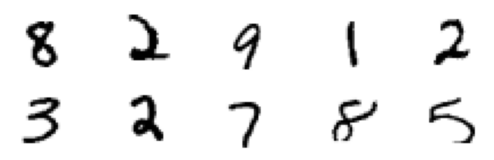

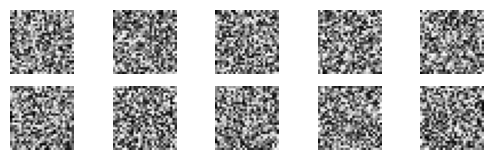

In [6]:
import numpy as np
import numpy.random as npr

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = npr.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = npr.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

real_samples = generate_real_samples(x_train, 10)
fake_samples = generate_fake_samples(10)

show_samples(real_samples, 10)
show_samples(fake_samples, 10)

>1 real=21% fake=47%
>2 real=45% fake=46%
>3 real=48% fake=45%
>4 real=49% fake=45%
>5 real=49% fake=46%
>6 real=50% fake=46%
>7 real=50% fake=47%
>8 real=50% fake=48%
>9 real=50% fake=48%
>10 real=51% fake=49%
>11 real=51% fake=49%
>12 real=51% fake=49%
>13 real=51% fake=50%
>14 real=51% fake=50%
>15 real=51% fake=50%
>16 real=52% fake=50%
>17 real=52% fake=50%
>18 real=52% fake=50%
>19 real=52% fake=50%
>20 real=52% fake=50%
>21 real=52% fake=51%
>22 real=52% fake=51%
>23 real=52% fake=51%
>24 real=52% fake=51%
>25 real=52% fake=51%
>26 real=52% fake=51%
>27 real=52% fake=51%
>28 real=52% fake=51%
>29 real=52% fake=51%
>30 real=52% fake=51%
>31 real=52% fake=51%
>32 real=52% fake=51%
>33 real=52% fake=51%
>34 real=52% fake=51%
>35 real=52% fake=52%
>36 real=52% fake=52%
>37 real=52% fake=52%
>38 real=52% fake=52%
>39 real=53% fake=52%
>40 real=53% fake=52%
>41 real=53% fake=52%
>42 real=53% fake=52%
>43 real=53% fake=53%
>44 real=53% fake=53%
>45 real=53% fake=53%
>46 real=53% fake=5

ValueError: cannot reshape array of size 28 into shape (28,28)

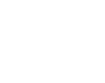

In [12]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model, x_train)

show_samples(x_test, 10)
results = model.predict(x_test)

In [10]:
for i in range(100):
    print(results[i])

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
